Author: Geoff Boeing
<br />
Web: http://geoffboeing.com
<br />
Date: 2014-09-06
<br />
Description: This notebook demos how to use geopandas to convert lat-long shapefiles and point data to a projected CRS, then plot them

In [1]:
# magic command to display matplotlib plots inline within the ipython notebook webpage
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib.font_manager as fm
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Polygon, Point
from descartes import PolygonPatch

In [2]:
# load the GPS location data set
df = pd.read_csv('data/summer-travel-gps-full.csv')
rs = pd.read_csv('data/summer-travel-gps-dbscan.csv')
rs.head()

,lat,lon,date,city,country
0,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom
1,38.781775,-9.137544,05/14/2014 15:11,Lisbon,Portugal
2,38.771939,-9.128911,05/14/2014 15:41,Lisbon,Portugal
3,38.742987,-9.147780,05/14/2014 16:11,Lisbon,Portugal
4,38.693780,-9.206363,05/15/2014 14:19,Lisbon,Portugal


In [3]:
# load the shapefile of world borders
all_countries = GeoDataFrame.from_file('shapefiles/world_borders/TM_WORLD_BORDERS-0.3.shp')
all_countries.head()

,AREA,FIPS,ISO2,ISO3,LAT,LON,NAME,POP2005,REGION,SUBREGION,UN,geometry
0,44,AC,AG,ATG,17.078,-61.783,Antigua and Barbuda,83039,19,29,28,"(POLYGON ((-61.686668 17.02444100000014, -61.7..."
1,238174,AG,DZ,DZA,28.163,2.632,Algeria,32854159,2,15,12,"POLYGON ((2.96361 36.802216, 2.981389 36.80693..."
2,8260,AJ,AZ,AZE,40.430,47.395,Azerbaijan,8352021,142,145,31,(POLYGON ((45.08332100000001 39.76804400000015...
3,2740,AL,AL,ALB,41.143,20.068,Albania,3153731,150,39,8,"POLYGON ((19.436214 41.021065, 19.450554 41.05..."
4,2820,AM,AM,ARM,40.534,44.563,Armenia,3017661,142,145,51,(POLYGON ((45.57305100000014 40.63248800000008...


## First plot the data set and shapefile, unprojected

In [4]:
# define the coordinates at the extent of our point data
margin_width = 4
lon_range = [rs['lon'].min() - margin_width, rs['lon'].max() + margin_width]
lat_range = [rs['lat'].min() - margin_width, rs['lat'].max() + margin_width]

# create a rectangle from these coordinates
spatial_extent = Polygon([(lon_range[0], lat_range[0]), 
                       (lon_range[0], lat_range[1]), 
                       (lon_range[1], lat_range[1]),
                       (lon_range[1], lat_range[0])])

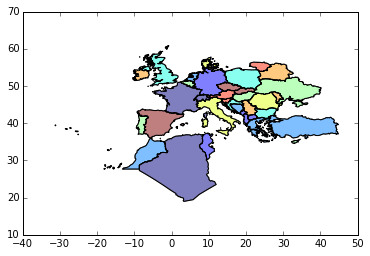

In [5]:
# select the country shapes within the spatial extents of our point data
countries = all_countries[all_countries['geometry'].intersects(spatial_extent)]
countries = countries[(countries['NAME'] != 'Russia') & (countries['NAME'] != 'Sweden')]
countries.plot()

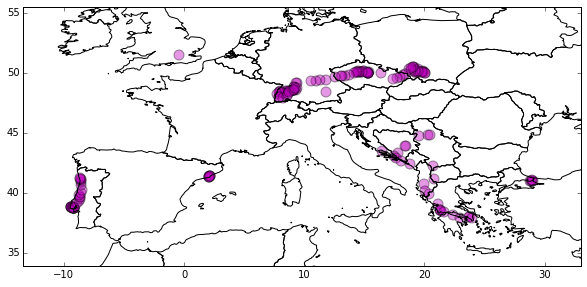

In [6]:
# plot the unprojected lat-long data
fig = plt.figure(figsize=(10, 10))

countries.plot(colormap='binary', alpha=0)
rs_scatter = plt.scatter(x=rs['lon'], y=rs['lat'], c='m', alpha=.4, s=100)

plt.xlim(lon_range)
plt.ylim(lat_range)
plt.show()

# it looks stretched out horizontally... lots of distortion at these latitudes if not projected...

## Now let's project this data set and shapefile

In [7]:
# re-load the whole shapefile and get its CRS
all_countries = GeoDataFrame.from_file('shapefiles/world_borders/TM_WORLD_BORDERS-0.3.shp')
all_countries['geometry'].crs

{u'datum': u'WGS84', u'no_defs': True, u'proj': u'longlat'}

In [8]:
# it comes with a .prj file specifying WGS84, aka EPSG:4326 - this is a generic world lat-long coordinate system
# things get pretty stretched at high latitudes like northern europe, so we should project it
# let's pick an appropriate projection for european latitudes

# the original CRS of our shapefile and point data
original_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'longlat'}

# the projected CRS to convert our shapefile and point data into
target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55, 'lat_0':45, 'lon_0':10}

# other examples of specifications for the to_crs() method
#target_epsg = '3575'
#target_epsg = '25831'
#target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'longlat'} # lat-long
#target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'robin'} # robinson projection
#target_crs = {'datum':'WGS84', 'no_defs':True, 'proj':'aea', 'lat_1':35, 'lat_2':55} # albers equal area

# for albers equal area: lat_1 and lat_2 are the upper and lower parallels, lat_0 and lon_0 form the false origin

In [9]:
# change the CRS of the shapefile to the specified projected one
all_countries.to_crs(crs=target_crs, inplace=True)
all_countries['geometry'].crs

{'datum': 'WGS84',
 'lat_0': 45,
 'lat_1': 35,
 'lat_2': 55,
 'lon_0': 10,
 'no_defs': True,
 'proj': 'aea'}

In [10]:
# create a geometry column in our point data set for geopandas to use
rs['geometry'] = None
for i, row in rs.iterrows():
    rs['geometry'][i] = Point(row['lon'], row['lat'])

# display the unprojected point data
rs.head()

,lat,lon,date,city,country,geometry
0,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom,POINT (-0.4460810000000001 51.47819910000001)
1,38.781775,-9.137544,05/14/2014 15:11,Lisbon,Portugal,POINT (-9.1375444 38.78177460000001)
2,38.771939,-9.128911,05/14/2014 15:41,Lisbon,Portugal,POINT (-9.128910599999999 38.771939)
3,38.742987,-9.147780,05/14/2014 16:11,Lisbon,Portugal,POINT (-9.1477802 38.74298710000001)
4,38.693780,-9.206363,05/15/2014 14:19,Lisbon,Portugal,POINT (-9.206363400000001 38.69377960000001)


In [11]:
# create a new geopandas geodataframe from the point data 
points = GeoDataFrame(rs)

# you must specify its original CRS to convert it to a different (projected) one later
points.crs = original_crs
points.head()

,lat,lon,date,city,country,geometry
0,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom,POINT (-0.4460810000000001 51.47819910000001)
1,38.781775,-9.137544,05/14/2014 15:11,Lisbon,Portugal,POINT (-9.1375444 38.78177460000001)
2,38.771939,-9.128911,05/14/2014 15:41,Lisbon,Portugal,POINT (-9.128910599999999 38.771939)
3,38.742987,-9.147780,05/14/2014 16:11,Lisbon,Portugal,POINT (-9.1477802 38.74298710000001)
4,38.693780,-9.206363,05/15/2014 14:19,Lisbon,Portugal,POINT (-9.206363400000001 38.69377960000001)


In [12]:
# convert the point data to the same projected CRS we specified earlier for our shapefile
points.to_crs(crs=target_crs, inplace=True)
points.head()

,lat,lon,date,city,country,geometry
0,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom,POINT (-716600.4651689383 775891.5996303955)
1,38.781775,-9.137544,05/14/2014 15:11,Lisbon,Portugal,POINT (-1634133.575546289 -508480.6745618258)
2,38.771939,-9.128911,05/14/2014 15:41,Lisbon,Portugal,POINT (-1633663.405585119 -509723.5808616227)
3,38.742987,-9.147780,05/14/2014 16:11,Lisbon,Portugal,POINT (-1635993.280910485 -512502.2805595197)
4,38.693780,-9.206363,05/15/2014 14:19,Lisbon,Portugal,POINT (-1642181.7948412 -516694.1408334156)


In [13]:
# convert the projected points into discrete x and y columns for easy matplotlib scatterplotting
points['x'] = None
points['y'] = None
for i, row in points.iterrows():
    points['x'][i] = row['geometry'].x
    points['y'][i] = row['geometry'].y
    
points.head()

,lat,lon,date,city,country,geometry,x,y
0,51.478199,-0.446081,05/14/2014 10:51,Hounslow,United Kingdom,POINT (-716600.4651689383 775891.5996303955),-716600.5,775891.6
1,38.781775,-9.137544,05/14/2014 15:11,Lisbon,Portugal,POINT (-1634133.575546289 -508480.6745618258),-1634134,-508480.7
2,38.771939,-9.128911,05/14/2014 15:41,Lisbon,Portugal,POINT (-1633663.405585119 -509723.5808616227),-1633663,-509723.6
3,38.742987,-9.147780,05/14/2014 16:11,Lisbon,Portugal,POINT (-1635993.280910485 -512502.2805595197),-1635993,-512502.3
4,38.693780,-9.206363,05/15/2014 14:19,Lisbon,Portugal,POINT (-1642181.7948412 -516694.1408334156),-1642182,-516694.1


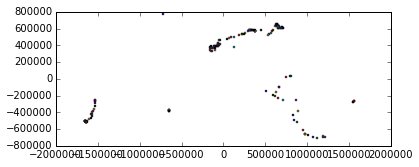

In [14]:
# plot the geodataframe of projected point data
# note the axes ticks are now northings and eastings (not lat-long coordinates) with (0,0) at the false origin we specified
points.plot()

In [15]:
# calculate some margin so our data doesn't go right up to the edges of the plotting figure
x_margin_width = (points.bounds['maxx'].max() - points.bounds['minx'].min()) / 10
y_margin_width = (points.bounds['maxy'].max() - points.bounds['miny'].min()) / 3

# define the coordinates at the extent of our projected point data
xlim = (points.bounds['minx'].min() - x_margin_width, points.bounds['maxx'].max() + x_margin_width)
ylim = (points.bounds['miny'].min() - y_margin_width, points.bounds['maxy'].max() + y_margin_width)

# create a rectangle from these coordinates
spatial_extent = Polygon([(xlim[0], ylim[0]), 
                       (xlim[0], ylim[1]), 
                       (xlim[1], ylim[1]),
                       (xlim[1], ylim[0])])

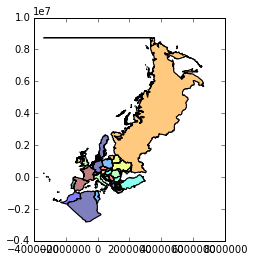

In [16]:
# select the country shapes within the spatial extents of our point data
countries = all_countries[all_countries['geometry'].intersects(spatial_extent)]

# plot the projected shapefile - see how it's different from the earlier plot
countries.plot()

In [17]:
# set dimensions in inches for the plotting figure size
xdim = (xlim[1] - xlim[0]) / 400000
ydim = (ylim[1] - ylim[0]) / 400000

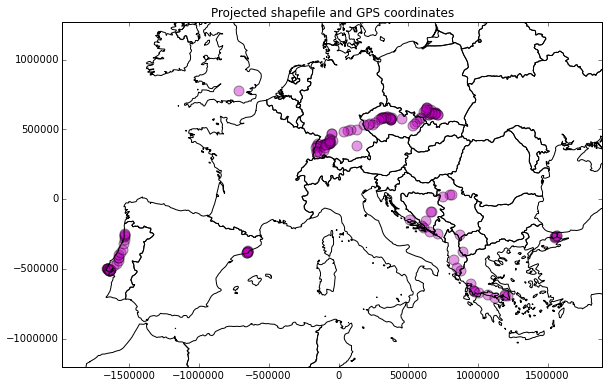

In [18]:
fig = plt.figure(figsize=(xdim, ydim))

# plot the projected shapefile and the projected GPS point data
countries.plot(colormap='binary', alpha=0)
points_scatter = plt.scatter(x=points['x'], y=points['y'], c='m', alpha=.4, s=100)

plt.title('Projected shapefile and GPS coordinates')
plt.xlim(xlim)
plt.ylim(ylim)

plt.show()

## Plot the map again, styled more nicely this time

In [19]:
# specify the colors and fonts for our map
facecolor = '#f7f7f7'
visited_facecolor = '#eeeeee'
edgecolor = '#cccccc'
backgroundcolor = '#e4f4ff'
title_font = fm.FontProperties(family='Bitstream Vera Sans', style='normal', size=15, weight='normal', stretch='normal')

In [20]:
# get a representative point for each of the most visited cities
most_index = df['city'].value_counts().head(6).index
most = pd.DataFrame(points[points['city'].isin(most_index)])
most.drop_duplicates(subset=['city'], take_last=False, inplace=True)
most

,lat,lon,date,city,country,geometry,x,y
1,38.781775,-9.137544,05/14/2014 15:11,Lisbon,Portugal,POINT (-1634133.575546289 -508480.6745618258),-1634134,-508480.7
35,41.387077,2.112232,05/20/2014 15:03,Barcelona,Spain,POINT (-650612.8545010423 -375851.6958494143),-650612.9,-375851.7
65,50.087729,14.660600,06/02/2014 12:10,Prague,Czech Republic,POINT (329263.3934799764 583235.1809137447),329263.4,583235.2
98,48.521902,9.055122,06/09/2014 12:12,Tübingen,Germany,POINT (-68815.19792553016 397819.2685319669),-68815.2,397819.3
149,37.968876,23.728140,07/05/2014 14:05,Athens,Greece,POINT (1192490.978255809 -690612.5656776736),1192491,-690612.6
152,40.979387,28.818796,07/06/2014 21:12,Istanbul,Turkey,POINT (1551495.72485398 -274664.5554497115),1551496,-274664.6


In [21]:
# create a list to contain a descartes PolygonPatch object for each Polygon in the GeoDataFrame geometry column
patches = []
for i, row in countries.iterrows():
    
    # if this row contains a Polygon object
    if type(row['geometry']) == Polygon:
        patch = PolygonPatch(row['geometry'], fc=facecolor, ec=edgecolor, zorder=0)
        patches.append(patch)
    
    # else, this row contains a MultiPolygon object - this is a shapely object that contains multiple Polygon objects
    # for example, countries that contain islands will have one Polygon shape for their mainland, and others for the island geometries
    else:
        # for each Polygon object in the MultiPolygon
        for polygon in row['geometry']:
            patch = PolygonPatch(polygon, fc=facecolor, ec=edgecolor, zorder=0)
            patches.append(patch)

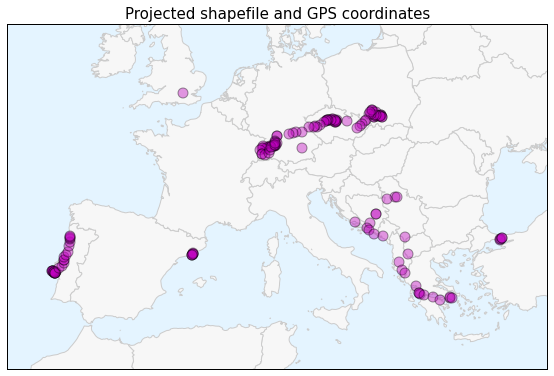

In [22]:
# create a figure, axis, and set the background color
fig = plt.figure(figsize=(xdim, ydim))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor(backgroundcolor)

# add each patch we extracted from the GeoDataFrame's geometry column to the axis
for patch in patches:
    ax.add_patch(patch)

# add the projected point data to the axis as a scatter plot
points_scatter = ax.scatter(x=points['x'], y=points['y'], c='m', alpha=0.4, s=100)

ax.set_title('Projected shapefile and GPS coordinates', fontproperties=title_font)

# set the axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# remove the tickmarks as these are projected geometries, the ticks are confusing northings/eastings
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [23]:
# plot the same thing again, but this time shade in the visited countries darker
# create a list to contain a descartes PolygonPatch object for each Polygon in the GeoDataFrame geometry column
patches = []

# get a list of visited countries so we can shade those patches a different color
visited_countries = rs['country'].unique()
countries = countries.replace('The former Yugoslav Republic of Macedonia', 'Macedonia (FYROM)')

for i, row in countries.iterrows():
    
    # if this row contains a Polygon object
    if type(row['geometry']) == Polygon:
        fc = visited_facecolor if row['NAME'] in visited_countries else facecolor
        patch = PolygonPatch(row['geometry'], fc=fc, ec=edgecolor, zorder=0)
        patches.append(patch)
    
    # else, this row contains a MultiPolygon object - this is a shapely object that contains multiple Polygon objects
    # for example, countries that contain islands will have one Polygon shape for their mainland, and others for the island geometries
    else:
        # for each Polygon object in the MultiPolygon
        for polygon in row['geometry']:
            fc = visited_facecolor if row['NAME'] in visited_countries else facecolor
            patch = PolygonPatch(polygon, fc=fc, ec=edgecolor, zorder=0)
            patches.append(patch)

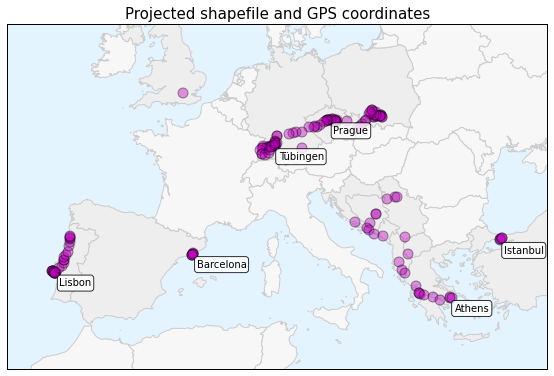

In [24]:
# create a figure, axis, and set the background color
fig = plt.figure(figsize=(xdim, ydim))
ax = fig.add_subplot(111)
ax.set_axis_bgcolor(backgroundcolor)

# add each patch we extracted from the GeoDataFrame's geometry column to the axis
for patch in patches:
    ax.add_patch(patch)

# add the projected point data to the axis as a scatter plot
points_scatter = ax.scatter(x=points['x'], y=points['y'], c='m', alpha=0.4, s=100)

ax.set_title('Projected shapefile and GPS coordinates', fontproperties=title_font)

# set the axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# remove the tickmarks as these are projected geometries, the ticks are confusing northings/eastings
ax.set_xticks([])
ax.set_yticks([])

# annotate the most visited cities on the map
for i, row in most.iterrows():
    plt.annotate(row['city'].decode('utf-8'), 
                 xy=(row['x'], row['y']),
                 xytext=(row['x'] + 35000, row['y'] - 100000),
                 bbox=dict(boxstyle='round', color='k', fc='w', alpha=0.8),
                 xycoords='data')

plt.show()

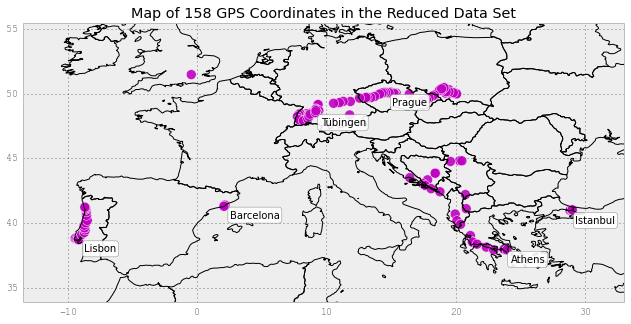

In [25]:
# compare that to the ugly stretched out default plot of the unprojected shapefile and data:
from IPython.display import Image
Image(filename='plots/matplotlib-map-points-shapefile.png')